tryed random forest,
Precision (macro): 0.860934
Recall (macro):    0.827522
F1 score (macro):  0.831007
auc:
'micro': 0.9895574070701553,
 'macro': 0.9894005847953218
 
 plus knn and stacking, not well

In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
from gensim.models import word2vec
import torch.nn as nn
import torch
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score,roc_auc_score

In [3]:
data=pd.read_csv('vdj_labelencoder.csv')

In [4]:
data

,complex.id,gene,cdr3,j.segm,species,mhc.a,mhc.b,mhc.class,antigen.epitope,antigen.gene,antigen.species,vdjdb.score,v.seg,d.segm
0,0,1,19577,55,0,31,0,0,187,138,11,2,56,6
1,0,1,19577,55,0,31,0,0,189,138,11,2,56,6
2,0,1,19577,55,0,31,0,0,190,138,11,2,56,6
3,0,1,19577,55,0,31,0,0,188,138,11,2,56,6
4,0,1,20005,64,0,95,8,1,547,69,28,1,91,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81946,30592,1,31608,58,0,95,8,1,678,70,29,0,94,6
81947,30593,0,12569,22,0,95,8,1,678,70,29,2,4,6
81948,30593,1,25621,62,0,95,8,1,678,70,29,2,76,6
81949,30594,0,57874,29,0,95,8,1,678,70,29,0,32,6


In [5]:
target=pd.Series(data['antigen.epitope'].value_counts())
print(len(target),sum(target))
print(len(target[target>20]),sum(target[target>20]))
t=target[target>20].index

1107 81951
153 77622


In [6]:
data = data[data['antigen.epitope'].map(data['antigen.epitope'].value_counts()) > 20] #drop the clusters with little data

<AxesSubplot:>

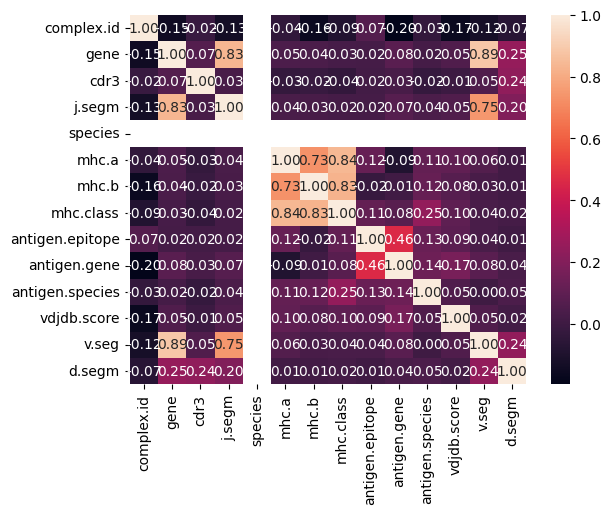

In [7]:
sns.heatmap(data.corr(),annot=True,fmt='.2f')

In [8]:
d几乎不相关，complex id 没有意义，species也没意义了

SyntaxError: invalid character '，' (U+FF0C) (369921315.py, line 1)

In [9]:
data.drop(['complex.id','d.segm','species'],axis=1,inplace=True)

C:\Users\15617\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [10]:
train_data, test_data = train_test_split(data, 
                                          stratify=data['antigen.epitope'], 
                                          train_size=0.8, 
                                          test_size=0.2)

In [11]:
X_train=train_data.drop('antigen.epitope',axis=1)
X_test=test_data.drop('antigen.epitope',axis=1)
y_train=train_data['antigen.epitope']
y_test=test_data['antigen.epitope']

最优参数： 41
最高得分： 0.9596135265700483


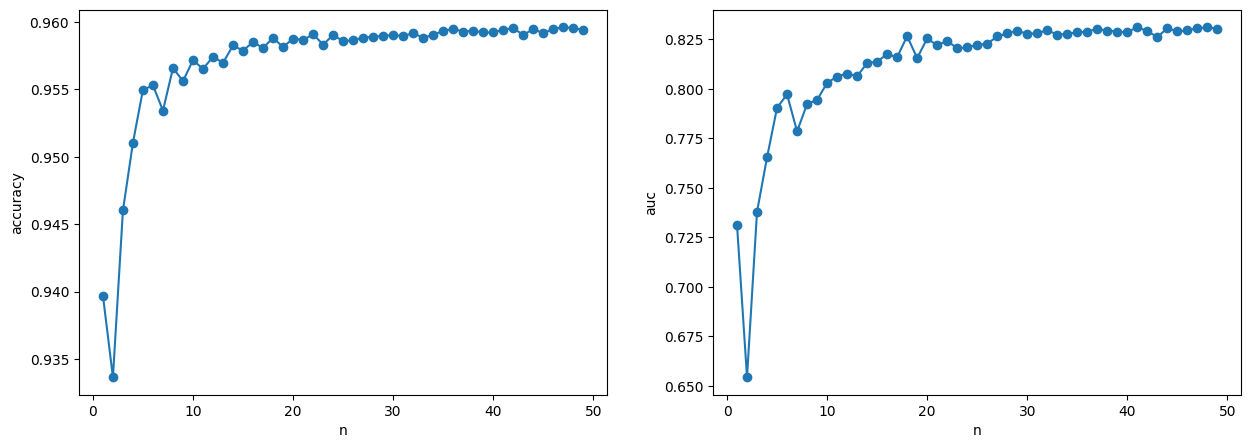

In [32]:

acc_scores=[]
acc_scores1 = []
nrange=range(1,50)
for n in nrange:
    rf = RandomForestClassifier(random_state=1,n_estimators=n)
    rf.fit(X_train, y_train)
    acc_scores.append(rf.score(X_test, y_test))
    acc_scores1.append(recall_score(y_test,rf.predict(X_test),average='macro'))
print("最优参数：",acc_scores1.index(max(acc_scores1))+1)
print("最高得分：",max(acc_scores))
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.xlabel('n')
plt.ylabel('accuracy')
plt.plot(nrange, acc_scores, marker='o')
plt.subplot(122)
plt.xlabel('n')
plt.ylabel('recall')
plt.plot(nrange, acc_scores1, marker='o')


In [14]:
rf = RandomForestClassifier(random_state=1,n_estimators=41)
rf.fit(X_train, y_train)
pre=rf.predict(X_test)
print("Precision (macro): %f" % precision_score(y_test, pre, average='macro'))
print("Recall (macro):    %f" % recall_score(y_test, pre, average='macro'))
print("F1 score (macro):  %f" % f1_score(y_test, pre, average='macro'), end='\n\n')
confusion_matrix_result = metrics.confusion_matrix(pre,y_test)
print('The confusion matrix result:\n',confusion_matrix_result)

Precision (macro): 0.860934
Recall (macro):    0.827522
F1 score (macro):  0.831007

The confusion matrix result:
 [[  6   0   0 ...   0   0   0]
 [  0   6   0 ...   0   0   0]
 [  0   0  17 ...   0   0   0]
 ...
 [  0   0   0 ... 370   0   0]
 [  0   0   0 ...   0  21   0]
 [  0   0   0 ...   0   0  23]]


In [43]:
np.shape(pre)

(15525,)

In [30]:
n_classes=153
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
y_label=np.eye(153)
y_score=metrics.confusion_matrix(rf.predict(X_test),y_test)
for i in range(153):
    fpr[i], tpr[i], _ = roc_curve(y_label[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


In [32]:

from scipy import interp

fpr["micro"], tpr["micro"], _ = roc_curve(y_label.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


C:\Users\15617\AppData\Local\Temp\ipykernel_10692\2654686421.py:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


In [33]:
roc_auc

{0: 0.993421052631579,
 1: 1.0,
 2: 1.0,
 3: 1.0,
 4: 1.0,
 5: 1.0,
 6: 1.0,
 7: 1.0,
 8: 1.0,
 9: 1.0,
 10: 1.0,
 11: 1.0,
 12: 1.0,
 13: 1.0,
 14: 1.0,
 15: 1.0,
 16: 0.993421052631579,
 17: 0.993421052631579,
 18: 1.0,
 19: 1.0,
 20: 1.0,
 21: 0.4967105263157895,
 22: 1.0,
 23: 1.0,
 24: 1.0,
 25: 1.0,
 26: 1.0,
 27: 1.0,
 28: 1.0,
 29: 1.0,
 30: 1.0,
 31: 1.0,
 32: 1.0,
 33: 1.0,
 34: 1.0,
 35: 1.0,
 36: 1.0,
 37: 1.0,
 38: 1.0,
 39: 1.0,
 40: 1.0,
 41: 1.0,
 42: 1.0,
 43: 1.0,
 44: 1.0,
 45: 1.0,
 46: 1.0,
 47: 0.9967105263157895,
 48: 1.0,
 49: 1.0,
 50: 1.0,
 51: 1.0,
 52: 1.0,
 53: 1.0,
 54: 0.993421052631579,
 55: 1.0,
 56: 1.0,
 57: 0.4934210526315789,
 58: 1.0,
 59: 0.9868421052631579,
 60: 1.0,
 61: 1.0,
 62: 1.0,
 63: 0.993421052631579,
 64: 1.0,
 65: 0.9868421052631579,
 66: 1.0,
 67: 1.0,
 68: 1.0,
 69: 1.0,
 70: 1.0,
 71: 1.0,
 72: 1.0,
 73: 1.0,
 74: 1.0,
 75: 1.0,
 76: 1.0,
 77: 1.0,
 78: 1.0,
 79: 1.0,
 80: 1.0,
 81: 1.0,
 82: 1.0,
 83: 1.0,
 84: 1.0,
 85: 1.0,
 86: 

最优参数： 1
最高得分： 0.9183424443576728


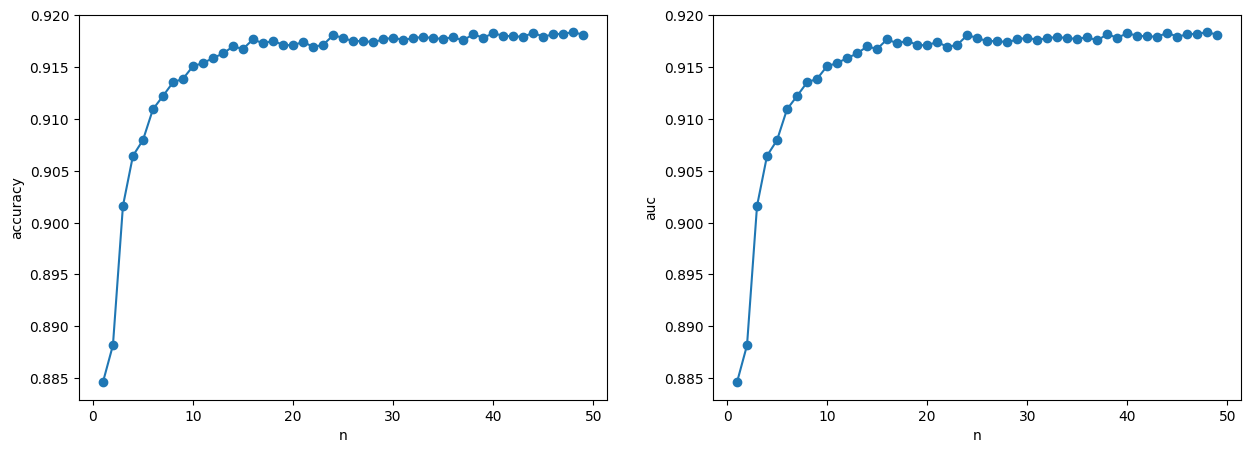

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score
acc_scores=[]
acc_scores1 = []
nrange=range(1,50)
for n in nrange:
    rf = RandomForestClassifier(random_state=1,n_estimators=n)
    rf.fit(X_train, y_train)
    acc_scores.append(rf.score(X_test, y_test))
    acc_scores1.append(recall_score(y_test,rf.predict(X_test),average='micro'))
print("最优参数：",acc_scores1.index(min(acc_scores1))+1)
print("最高得分：",max(acc_scores))
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.xlabel('n')
plt.ylabel('accuracy')
plt.plot(nrange, acc_scores, marker='o')
plt.subplot(122)
plt.xlabel('n')
plt.ylabel('auc')
plt.plot(nrange, acc_scores1, marker='o')


In [15]:
print("最优参数：",acc_scores1.index(max(acc_scores1))+1)
print("最高得分：",max(acc_scores))

最优参数： 48
最高得分： 0.9183424443576728


Max accuracy score: 0.7263276064037485


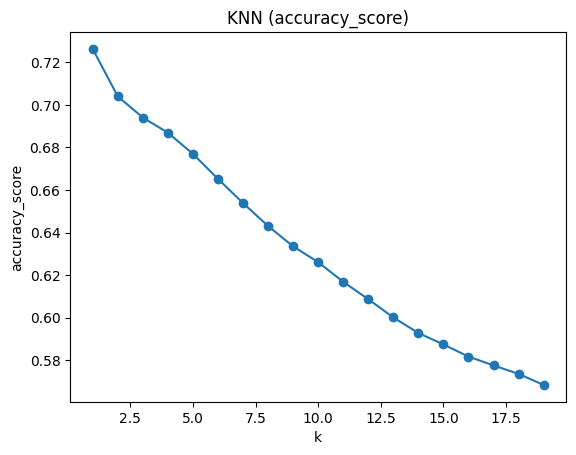

In [24]:
from sklearn.neighbors import KNeighborsClassifier
t_range = range(1, 20)
acc_scores = []
for t in t_range:
    clf = KNeighborsClassifier(n_neighbors=t)
    clf = clf.fit(X_train, y_train)
    acc_scores.append(metrics.accuracy_score(y_test,clf.predict(X_test)))
print('Max accuracy score:',max(acc_scores))    
plt.xlabel('k')
plt.ylabel('accuracy_score')
plt.title('KNN (accuracy_score)')
plt.plot(t_range, acc_scores, marker='o')

In [25]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1,n_estimators=48)
clf3 = SVC()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=lr)
 
print('3-fold cross validation:\n')
 
for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'SVC',
                       'StackingClassifier']):
 
    scores = model_selection.cross_val_score(clf, X, y, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:



D:\python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Accuracy: 0.69 (+/- 0.02) [KNN]


D:\python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Accuracy: 0.90 (+/- 0.01) [Random Forest]


D:\python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Accuracy: 0.34 (+/- 0.00) [SVC]


D:\python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
D:\python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please 

Accuracy: 0.59 (+/- 0.02) [StackingClassifier]
